In [3]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from sympy.utilities.iterables import multiset_permutations
import itertools as it
import copy
import sys
import seaborn as sns
from random import seed
from random import random
from random import randint
from random import uniform
from datetime import datetime

In [4]:
#Raising operator coefficient calculation
def bondcoefficient(j,m,i):
        return np.sqrt(j*(j+1) - m[i]*(m[i]+1))
#Note these appear to be seperate from the Christandl hopping coefficients

In [60]:
#This block is used to calculate all the permuatations of a particular list and compile them into an array
state = [[1,0,0,0,0,0],[0,0,0,0,0,1]] #Note for getting particles to start on opposite ends of the chain use Line 12 st_dwn = st_down[::-1]
state_up_set = multiset_permutations(state[0])
state_down_set = multiset_permutations(state[1])
states_up = []
states_down = []
for i in state_up_set:
   states_up.append(i)
for i in state_down_set:
   states_down.append(i)
#states_down = states_down[::-1] #Changes which side spin down e- starts on
#print(states_up)
#print(states_down)
states = []
for i in states_up:
   for j in states_down:
      states.append([i,j])
#instantiate psi_0
N = len(states)
psi_0 = [0]* N
psi_0[0] += 1
#print(psi_0)
#note state_arr (array) is used to order the state (basis) vectors in the way we do by hand.
state_arr = []
for i in states:
   state_arr.append(i)
state_arr.reverse()
#index_0 = state_arr.index(state)
print(state_arr)
#print("initial state: " , psi_0)
#print("basis vectors:", state_arr)
#print("Number of basis vectors:" , N)

[[[1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]], [[1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]], [[1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]], [[1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0]], [[1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1]], [[0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [[0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]], [[0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]], [[0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]], [[0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0]], [[0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1]], [[0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [[0, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 0]], [[0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0]], [[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0]], [[0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0]], [[0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1]], [[0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0]], [[0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 0]], [[0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 0]], [[0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 0]], [[0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0]], [[0, 0, 0, 1, 0, 0], [0, 0, 0, 0,

In [61]:
#Andy's algorithm for identifying possible transition sites. 
def check_jumps(state):
    N = len(state[0])
    jump_arr = []
    for i in range(N):
        if state[0][i] != 0:
            if i > 0:
                if state[0][i - 1] == 0: # non interacting
                    upleftjump = copy.deepcopy(state)
                    upleftjump[0][i-1] += upleftjump[0][i]
                    upleftjump[0][i] -= upleftjump[0][i]
                    jump_arr.append([i, -1, upleftjump, state])
            if i < N - 1:
                if state[0][i + 1] == 0: # non interacting
                    uprightjump = copy.deepcopy(state)
                    uprightjump[0][i+1] += uprightjump[0][i]
                    uprightjump[0][i] -= uprightjump[0][i]
                    jump_arr.append([i, 1, uprightjump, state])
        if state[1][i] != 0:
            if i > 0:
                if state[1][i - 1] == 0: # non interacting
                    leftjump = copy.deepcopy(state)
                    leftjump[1][i-1] += leftjump[1][i]
                    leftjump[1][i] -= leftjump[1][i]
                    jump_arr.append([i, -1, leftjump, state])
            if i < N - 1:
                if state[1][i + 1] == 0: # non interacting
                    rightjump = copy.deepcopy(state)
                    rightjump[1][i+1] += rightjump[1][i]
                    rightjump[1][i] -= rightjump[1][i]
                    jump_arr.append([i, 1, rightjump, state])
    return jump_arr

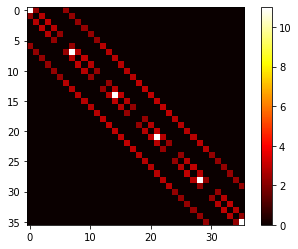

In [62]:
#A rework of the Hamiltonian generator, with hoppings
#generated before the code for H is run.
# This code works fine, and allows for monte carlo simulation to adjust
# hopping values and then generate the new H 
b_arr = []
# calculate spin orbit coupling values
sites = len(state[0])
j = (sites-1)/2
m = np.arange(start = -j,stop = j +1 , step = 1)
#print(m)
# calculate bond coefficients    
for i in range(0,len(m)):
    b = bondcoefficient(j,m,i)
    b_arr.append(b)
#print(b_arr)

def H(N,U,b_arr = b_arr):
    H = np.zeros(shape = (N,N))
    jumps_arrs = []
    #input Jumping coefficients and mu values into the Hamiltonian
    for i in state_arr:
        jumps_arrs += check_jumps(i)
    #print(jumps_arrs)
    for i in jumps_arrs:
        x = state_arr.index(i[3])
        y = state_arr.index(i[2])
        #print(i)
        #this if statement controls the mu values. 
        if (i[3][0] == i[3][1]):
            H[x][x] = U
        #these statements control the placement of the hopping values
        if i[1] < 0:
            H[x][y] = b_arr[i[0] + i[1]]
        else:
            H[x][y] = b_arr[i[0]]
    np.set_printoptions(threshold=np.inf)
    return H

#System Parmeters
t_final = 10*np.pi
U = 11
N = len(states)
#Hamiltonian Colormap
plt.imshow(H(N,U,b_arr), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

#WORKS

In [63]:
#find the eigen values and eigen vectors of the Hamiltonian.
eigvals, eigvecs = LA.eigh(H(N,U))
print(np.round(eigvals,3))
#print(np.around(eigvecs,3))
#print(psi_0)
c_n =  np.inner(np.transpose(eigvecs), psi_0)

#this block allows for the time evolution of probabilities for all basis to be calculated
#key to getting prob as an iterable list of lists was using list comprehension
#to define the list of lists.
prob = [[] for x in range(len(c_n))]
eigvecs = np.transpose(eigvecs)
for t in np.arange(0,t_final,0.01):
    psi_t = []
    count = 0  
    for i in range(0, len(c_n)):
        count += c_n[i]*np.exp(complex(0, -eigvals[i]*t))*eigvecs[i]
    psi_t.append(count)
    psi_t = np.array(psi_t)
    #print("psi_t: ")
    #print(psi_t)
    probability = (psi_t.real**2 + psi_t.imag**2)
    for i in range(0, len(c_n)):
        prob[i].append(probability[0][i])
prob = np.asarray(prob)


[-8.718 -8.    -6.66  -6.    -4.933 -4.588 -4.    -4.    -2.845 -2.493
 -2.    -2.    -1.    -0.724 -0.352 -0.    -0.     0.     1.128  1.467
  2.     2.     3.022  3.341  4.     4.     5.243  6.     7.164  8.
 11.    11.352 12.026 12.972 14.135 15.466]


Text(0.5, 1.0, 'Site Occupation Probabilities w/ U = 11')

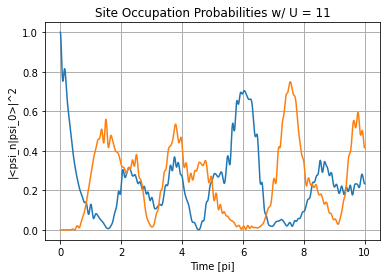

In [64]:
#block for graphing the probabilities vs time
t = np.arange(0, len(prob[0]))
t = t/(100*np.pi) # 100*np.pi is a scaling factor

#for x in range(len(prob)):#Plot every state
 # plt.plot(t,prob[x])

for x in range(len(prob)): #PLOT INITIAL STATE AND FIDELITY
    if x == 0 or x == len(prob)-1:
        if x == 0:
            plt.plot(t,prob[x]) #Plot of the initial state of the system
        else:
            plt.plot(t,prob[x]) #Plot of the Fidelity of the system
    else:
        pass
plt.xlabel('Time [pi]')
plt.ylabel('|<psi_n|psi_0>|^2')
plt.grid(linewidth = 1)
plt.title('Site Occupation Probabilities w/ U = '  + str(U))

In [65]:
#Fidelity at target time vs U
def FvU(U):
    eigvals, eigvecs = LA.eigh(H(N,U))
    eigvecs = np.transpose(eigvecs)
    c_n =  np.inner(eigvecs, psi_0)
    prob = [[] for x in range(len(c_n))]
    psi_t = []
    count = 0  
    tau = np.pi
    for i in range(0, len(c_n)):
        count += c_n[i]*np.exp(complex(0, -eigvals[i]*tau))*eigvecs[i]
    psi_t.append(count)
    psi_t = np.array(psi_t)
    probability = (psi_t.real**2 + psi_t.imag**2)
    for i in range(0, len(c_n)):
        prob[i].append(probability[0][i])
    prob = np.asarray(prob)
    #print(prob)
    return prob[len(prob)-1][0]

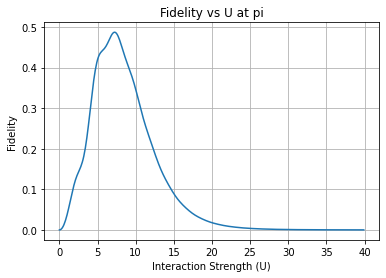

In [66]:
x = np.arange(0,40,0.1) #this is the range of interaction strengths being tested
U_list = []
F_list = []
for i in x:
    U_list.append(i)
    F_list.append(FvU(i))
plt.plot(U_list, F_list)
plt.title("Fidelity vs U at pi")
plt.xlabel("Interaction Strength (U)")
plt.ylabel("Fidelity")
plt.grid()

In [67]:
def maxFvU(U):
    eigvals, eigvecs = LA.eigh(H(N,U))
    c_n =  np.inner(np.transpose(eigvecs), psi_0)
    prob = [[] for x in range(len(c_n))]
    eigvecs = np.transpose(eigvecs)
    for t in np.arange(0,t_final,0.01):
        psi_t = []
        count = 0  
        for i in range(0, len(c_n)):
            count += c_n[i]*np.exp(complex(0, -eigvals[i]*t))*eigvecs[i]
        psi_t.append(count)
        psi_t = np.array(psi_t)
        probability = (psi_t.real**2 + psi_t.imag**2)
        for i in range(0, len(c_n)):
            prob[i].append(probability[0][i])
    prob = np.asarray(prob)

    max_Fidelity = [prob[len(prob)-1][0]]
    for i in prob[len(prob)-1]:
        if i > max_Fidelity[0]:
            max_Fidelity[0] = i
        else:
            pass

    return(max_Fidelity[0])

maxFvU(10)

0.8165418208668469

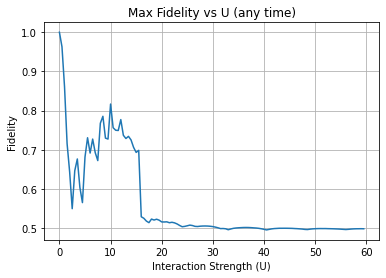

In [68]:
x = np.arange(0,60,0.5) #this is the range of interaction strengths being tested
U_list = []
F_list = []
for i in x:
    U_list.append(i)
    F_list.append(maxFvU(i))
plt.plot(U_list, F_list)
plt.title("Max Fidelity vs U (any time)")
plt.xlabel("Interaction Strength (U)")
plt.ylabel("Fidelity")
plt.grid()

In [69]:
#These are the U values where the Fidelity is maximized in these
#systems. They'll be beneficial in testing the Monte Carlo 
#simulations as it will give the specific U values that the Fidelity
#should be maximized at. 
# Unless this value also changes as we perturbe the hopping coefficients

Max_U = []
Max_F = []
for i in range(0,len(F_list)-1):
    if F_list[i] > F_list[i-1] and F_list[i] > F_list[i+1]:
        Max_U.append(U_list[i])
        Max_F.append(F_list[i])
    else:
        pass
print(Max_U)
print(np.around(Max_F,3))
print("Average F_max: " + str(np.average(Max_F)))

[0.0, 3.5, 5.5, 6.5, 8.5, 10.0, 12.0, 13.5, 15.5, 18.0, 19.0, 21.0, 22.0, 25.5, 28.5, 32.0, 36.5, 43.0, 44.0, 51.0, 52.0, 59.0]
[1.    0.676 0.73  0.727 0.785 0.817 0.777 0.734 0.698 0.523 0.522 0.516
 0.514 0.507 0.505 0.499 0.501 0.499 0.499 0.498 0.498 0.498]
Average F_max: 0.6147685113570778


In [70]:
#Block to look at target times for a given U value for the 
#system denoted at the beginning of the code.
U = 53.5
eigvals, eigvecs = LA.eigh(H(N,U))
c_n =  np.inner(np.transpose(eigvecs), psi_0)
prob = [[] for x in range(len(c_n))]
eigvecs = np.transpose(eigvecs)
for t in np.arange(0,t_final,0.01):
    psi_t = []
    count = 0  
    for i in range(0, len(c_n)):
        count += c_n[i]*np.exp(complex(0, -eigvals[i]*t))*eigvecs[i]
    psi_t.append(count)
    psi_t = np.array(psi_t)
    probability = (psi_t.real**2 + psi_t.imag**2)
    for i in range(0, len(c_n)):
        prob[i].append(probability[0][i])
prob = np.asarray(prob)
t = np.arange(0, len(prob[0]))
t = t/(100*np.pi) # 100*np.pi is a scaling factor

tau_list = []
result = np.where(prob[len(prob)-1] == np.amax(prob[len(prob)-1]))
tau_list.append(result[0][0]/(100*np.pi))
print("target time: " + str(tau_list[0]) + '[units pi]')

target time: 6.515803370182195[units pi]


In [71]:
def F(U, tau, arr):
    eigvals, eigvecs = LA.eigh(H(N,U,arr))
    eigvecs = np.transpose(eigvecs)
    c_n =  np.inner(eigvecs, psi_0)
    prob = [[] for x in range(len(c_n))]
    psi_t = []
    count = 0  
    for i in range(0, len(c_n)):
        count += c_n[i]*np.exp(complex(0, -eigvals[i]*tau))*eigvecs[i]
    psi_t.append(count)
    psi_t = np.array(psi_t)
    probability = (psi_t.real**2 + psi_t.imag**2)
    for i in range(0, len(c_n)):
        prob[i].append(probability[0][i])
    prob = np.asarray(prob)
    #print(prob)
    return prob[len(prob)-1][0]

In [72]:
print(F(10.5, np.pi/2,b_arr))

0.0013683466335952898


In [78]:
def MonteCarlo(U,tau,steps,b_arr):
    T = 1000
    new_barr = b_arr.copy()
    print(new_barr)
    newF_arr = []
    step_arr = []
    acc = 0
    rej = 0
    for i in range(steps):
        seed(datetime.now())
        update = new_barr.copy()
        update[randint(0, len(b_arr)-2)] += uniform(-0.05,0.05)
        F_new = F(U,tau,update)
        F_0 = F(U,tau,new_barr)
        newF_arr.append(F_new)
        step_arr.append(i)
        #print("update")
        #print( update)
        #print(F_new)
        #print(F_0)
        dF = F_new - F_0
        #P = np.exp(-dF*T) #Metropolis
        P = np.exp(-dF*T)/(1+np.exp(-dF*T)) #Heat bath
        
        if dF > 0.00 :
           # print("accepted")
            new_barr = update
            acc += 1
        else:
            #print("rejected")
            if P < random():
                acc += 1
                #print("Pvr: ")
                #print(P)
                #print(random())
                new_barr = update
            else: 
                rej += 1
                pass
        T -= 1/(steps)
        #print("new Barr")
        #print( new_barr)
    plt.plot(step_arr,newF_arr)
    plt.xlabel("Iterations")
    plt.ylabel("Fidelity")
    plt.title("Fidelity vs Iterations")
    plt.grid()
    print("accepted: " + str(acc))
    print("rejected: " + str(rej))
    print(newF_arr[len(newF_arr)-1])

    return new_barr

[3.0, 3.0, 3.0, 3.0, 3.0, 0.0]
accepted: 3069
rejected: 6931
0.9394049645792178
[2.8798710749563163, 3.1625489279795818, 2.807089082394369, 3.393015001147097, 2.871066343375583, 0.0]


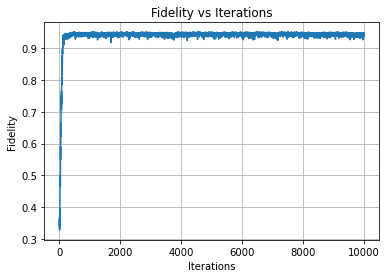

In [79]:
U = 28.76827052
tau = np.pi
steps = 10000
print(MonteCarlo(U,19.92559642,steps,[3.0,3.0,3.0,3.0,3.0,0.0]))
#print(MonteCarlo(U,tau,steps,b_arr))

In [80]:
def time_evolve(N,U,arr,t_final):
    #find the eigen values and eigen vectors of the Hamiltonian.
    eigvals, eigvecs = LA.eigh(H(N,U,arr))
    print(np.round(eigvals,3))
    #print(np.around(eigvecs,3))
    #print(psi_0)
    c_n =  np.inner(np.transpose(eigvecs), psi_0)

    #this block allows for the time evolution of probabilities for all basis to be calculated
    #key to getting prob as an iterable list of lists was using list comprehension
    #to define the list of lists.
    prob = [[] for x in range(len(c_n))]
    eigvecs = np.transpose(eigvecs)
    for t in np.arange(0,t_final,0.01):
        psi_t = []
        count = 0  
        for i in range(0, len(c_n)):
            count += c_n[i]*np.exp(complex(0, -eigvals[i]*t))*eigvecs[i]
        psi_t.append(count)
        psi_t = np.array(psi_t)
        #print("psi_t: ")
        #print(psi_t)
        probability = (psi_t.real**2 + psi_t.imag**2)
        for i in range(0, len(c_n)):
            prob[i].append(probability[0][i])
    prob = np.asarray(prob)
    #block for graphing the probabilities vs time
    t = np.arange(0, len(prob[0]))
    t = t/(100*np.pi) # 100*np.pi is a scaling factor

    #for x in range(len(prob)):#Plot every state
    # plt.plot(t,prob[x])

    for x in range(len(prob)): #PLOT INITIAL STATE AND FIDELITY
        if x == 0 or x == len(prob)-1:
            if x == 0:
                plt.plot(t,prob[x]) #Plot of the initial state of the system
            else:
                plt.plot(t,prob[x]) #Plot of the Fidelity of the system
        else:
            pass
    plt.xlabel('Time [pi]')
    plt.ylabel('|<psi_n|psi_0>|^2')
    plt.grid(linewidth = 1)
    plt.title('Site Occupation Probabilities w/ U = '  + str(U)) 
    return 0   
    

[-8.342 -8.017 -6.311 -6.022 -4.439 -4.262 -4.014 -4.003 -2.379 -2.214
 -2.019 -1.995 -0.469 -0.31  -0.139 -0.    -0.    -0.     1.618  1.802
  1.995  2.019  3.558  3.748  4.003  4.014  5.713  6.022  7.665  8.017
 28.768 28.907 29.182 29.592 30.126 30.796]
0


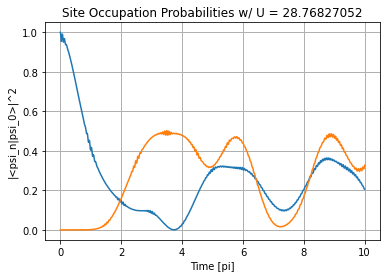

In [81]:
print(time_evolve(N,28.76827052,[2.2480215920995947, 2.8421710664112134, 3.023340383126551, 2.8221400287513307, 2.2240072253269565, 0.0],10*np.pi))


[-56.139 -41.199 -38.022 -30.152 -29.837 -28.653 -28.197 -21.345 -17.606
 -14.187 -12.546 -11.955 -11.047 -10.29   -0.254   0.      0.      0.
   1.947   7.021   7.779   9.957  11.047  12.546  13.293  14.79   17.606
  21.037  26.898  28.653  29.053  30.152  30.828  41.199  45.278  62.089]
0


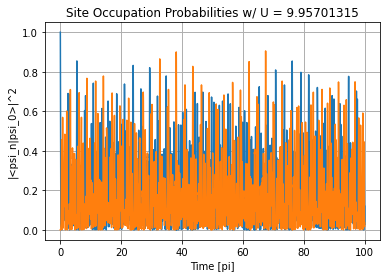

In [82]:
print(time_evolve(N,9.95701315,[3.76293832,  17.87407559,  18.35558138, 17.87407559, 3.76293832],100*np.pi))
